# Antonym Word Relation Establishment

In [1]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import gensim.downloader
#Import numpy for array calculation|
import numpy as np

import re

#import nltk for string operations
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize

import relations

In [2]:
# import word list
imported_tuples = relations.read_relations("./relations/antonyms.txt")

In [99]:
# Load the model
model = gensim.downloader.load('glove-wiki-gigaword-50')
dims = 50

In [100]:
# preprocess data
antonym_tuples = []
for tup in imported_tuples:
    if " " not in tup[0].strip() and " " not in tup[1].strip():
        antonym_tuples.append((tup[0].strip().lower(), tup[1].strip().lower()))

In [77]:
# conversion to vectors
antonym_vectors = []
for tup in antonym_tuples:
    if tup[0] in model.vocab and tup[1] in model.vocab:
        antonym_vectors.append((model.get_vector(tup[0]), model.get_vector(tup[1])))

## Multi-Variate Linear Regression

Given the input vector, the aim is to create a model that outputs its antonym vector. 
The output variable has multiple dimensions, the strategy is to regress over each dimension and get coefficients for each dimension.

In [78]:
from sklearn.linear_model import LinearRegression

In [79]:
# create a coefficients array
coeff = []
intercepts = []
avg_score = 0
# regressing a linear model on each independent dimension of response variable
for i in range(dims):
    y = [x[0][i] for x in antonym_vectors]
    x = [tup[1] for tup in antonym_vectors]
    regr = LinearRegression()
    regr.fit(x, y)
    coeff.append(regr.coef_)
    intercepts.append(regr.intercept_)
    avg_score += regr.score(x,y)
print("Model score: ", avg_score/dims)

Model score:  0.308727771650265


The model has a very low accuracy, lower than it had when the data set was smaller. An explanation could be that words are used in more than one context unlike country-capital vectors and hence don't have a simple relationship.

## Relation Establishment using Neural Nets

In [80]:
# importing the required libs
from keras.models import Sequential
from keras.layers import Dense
import keras

import math
from scipy import spatial

In [81]:
# Data preparation
X = [x[0] for x in antonym_vectors]
y = [x[1] for x in antonym_vectors]

In [97]:
nn = Sequential()
nn.add(Dense(12, input_dim=dims, activation='sigmoid'))
nn.add(Dense(12, activation='relu'))
nn.add(Dense(12, activation='relu'))
nn.add(Dense(12, activation='sigmoid'))
nn.add(Dense(dims, activation='linear'))
nn.compile(loss='mean_squared_error', optimizer='sgd', metrics=['accuracy'])

In [98]:
# fit the keras model on the dataset
history = nn.fit(np.array(X), np.array(y), epochs=15, batch_size=20)

Epoch 1/15
1749/1749 [==============================] - 0s 108us/step - loss: 0.9157 - accuracy: 0.0154
Epoch 2/15
1749/1749 [==============================] - 0s 61us/step - loss: 0.6898 - accuracy: 0.2093
Epoch 3/15
1749/1749 [==============================] - 0s 58us/step - loss: 0.5663 - accuracy: 0.3928
Epoch 4/15
1749/1749 [==============================] - 0s 58us/step - loss: 0.4974 - accuracy: 0.3928
Epoch 5/15
1749/1749 [==============================] - 0s 59us/step - loss: 0.4592 - accuracy: 0.3928
Epoch 6/15
1749/1749 [==============================] - 0s 62us/step - loss: 0.4381 - accuracy: 0.3928
Epoch 7/15
1749/1749 [==============================] - 0s 66us/step - loss: 0.4266 - accuracy: 0.3928
Epoch 8/15
1749/1749 [==============================] - 0s 64us/step - loss: 0.4204 - accuracy: 0.3928
Epoch 9/15
1749/1749 [==============================] - 0s 61us/step - loss: 0.4171 - accuracy: 0.3928
Epoch 10/15
1749/1749 [==============================] - 0s 64us/step - 

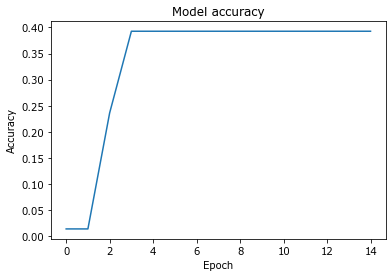

In [85]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [86]:
pred_val = nn.predict(np.array([model.get_vector("lazy")]))
actual_val = model.get_vector("active")

In [87]:
# cosine similarity functions
def calculate_cosine_distance(a, b):
    cosine_distance = float(spatial.distance.cosine(a, b))
    return cosine_distance

def calculate_cosine_similarity(a, b):
    cosine_similarity = 1 - calculate_cosine_distance(a, b)
    return cosine_similarity

In [88]:
calculate_cosine_similarity(pred_val, actual_val)

0.7912224531173706